## HI-VAEによる因果推論実験
#### 10変数
##### 2019年3月24日  Team15 Hiroshi Sasaki @molhineko

In [1]:
import tensorflow as tf
import graph_new
import parser_arguments
import time
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from matplotlib import pyplot as plt
#import plot_functions
import read_functions
import os
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)

In [2]:
def print_loss(epoch, start_time, avg_loss, avg_test_loglik, avg_KL_s, avg_KL_z):
    print("Epoch: [%2d]  time: %4.4f, train_loglik: %.8f, KL_z: %.8f, KL_s: %.8f, ELBO: %.8f, Test_loglik: %.8f"
          % (epoch, time.time() - start_time, avg_loss, avg_KL_z, avg_KL_s, avg_loss-avg_KL_z-avg_KL_s, avg_test_loglik))


plt.close('all')

In [3]:
size = 70000
treat = np.random.binomial(1,0.5,size=size)
effect = 1.5
beta2 = 0.8
beta3 = 0.3
beta4 = 0.5

beta5 = 0.4
beta6 = 0.3
beta7 = 0.5
beta8 = 0.3
beta9 = 0.2
beta10 = 0.2

eps = 1e-10
#b = np.random.normal(3,0.2)
b = 0
def mkdata(x1=treat,effect=effect,beta2=beta2,beta3=beta3, beta4=beta4,beta5=beta5,beta6=beta6,beta7=beta7,beta8=beta8,\
          beta9=beta9,beta10=beta10, b=b,size=size):
    #x1 = np.random.binomial(1,0.5,size=size)
    x2 = np.random.normal(1.4*x1+0.4,2.0,size=size)
    x3 = np.random.normal(-0.8*x1+1.3*x2,0.5,size=size)
    x4 = np.random.normal(0.2*x1+-0.9*x2+2.3*x3,0.4,size=size)
    
    x5 = np.random.normal(0.4*x1+0.4,2.0,size=size)
    x6 = np.random.normal(-0.3*x1+1.5*x5+0.2,2.5,size=size)
    x7 = np.random.normal(0.2*x1+1.5*x5-1.4*x6,1.4,size=size)
    x8 = np.random.normal(1.0*x1+2.3*x7+1.2*x5,2.0,size=size)
    x9 = np.random.normal(-0.8*x1+0.4*x6+0.6*x2,1.5,size=size)
    x10 = np.random.normal(0.2*x1+0.5,1.4,size=size)
    
    yogo= effect*x1+beta2*x2+beta3*x3+beta4*x4+beta5*x5+beta6*x6+beta7*x7+beta8*x8+beta9*x9+beta10*x10+b
    return(np.array((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,yogo)).T)

split_point = 60000

data = mkdata(x1=treat,size=size)
train = np.array(data[:split_point])#train[:,0]:conditional, train[:,1:10]:feature, train[:,10]:outcome
test = np.array(data[split_point:])

In [4]:
df_train = pd.DataFrame(train)

In [5]:
train_data_hivae = np.array(data[:,1:10])
df_train_data_hivae = pd.DataFrame(train_data_hivae)
df_train_data_hivae.to_csv('transfusion/10_dim.csv', header=False, index=False)

In [6]:
df_data_types = pd.DataFrame({'type':['real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real'],
                              'dim':[1, 1, 1, 1, 1, 1, 1, 1, 1],
                              'nclass':[None, None, None, None, None, None, None, None, None]})
df_data_types.to_csv('transfusion/data_types.csv', index=False)

In [7]:
settings = '--epochs 200 --model_name model_HIVAE_inputDropout --restore 0 --train 1 \
            --data_file transfusion/10_dim.csv --types_file transfusion/data_types.csv --miss_file transfusion/Missing_0.csv \
            --batch_size 100 --save 1001 --save_file transfusion_model_test\
            --dim_latent_s 7 --dim_latent_z 7 --dim_latent_y 5 \
            --miss_percentage_train 0.0 --miss_percentage_test 0.0'

In [8]:
argvals = settings.split()
args = parser_arguments.getArgs(argvals)
argvals

['--epochs',
 '200',
 '--model_name',
 'model_HIVAE_inputDropout',
 '--restore',
 '0',
 '--train',
 '1',
 '--data_file',
 'transfusion/10_dim.csv',
 '--types_file',
 'transfusion/data_types.csv',
 '--miss_file',
 'transfusion/Missing_0.csv',
 '--batch_size',
 '100',
 '--save',
 '1001',
 '--save_file',
 'transfusion_model_test',
 '--dim_latent_s',
 '7',
 '--dim_latent_z',
 '7',
 '--dim_latent_y',
 '5',
 '--miss_percentage_train',
 '0.0',
 '--miss_percentage_test',
 '0.0']

In [9]:
#Create a directoy for the save file
if not os.path.exists('./Saved_Networks/' + args.save_file):
    os.makedirs('./Saved_Networks/' + args.save_file)

network_file_name='./Saved_Networks/' + args.save_file + '/' + args.save_file +'.ckpt'
log_file_name='./Saved_Network/' + args.save_file + '/log_file_' + args.save_file +'.txt'

print(args)

Namespace(batch_size=100, data_file='transfusion/10_dim.csv', dim_latent_s=7, dim_latent_y=5, dim_latent_y_partition=None, dim_latent_z=7, display=1, epochs=200, miss_file='transfusion/Missing_0.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=1001, save_file='transfusion_model_test', train=1, true_miss_file=None, types_file='transfusion/data_types.csv')


In [10]:
#Creating graph
sess_HVAE = tf.Graph()

In [11]:
with sess_HVAE.as_default():
    
    tf_nodes = graph_new.HVAE_graph(args.model_name, args.types_file, args.batch_size,
                                    learning_rate=1e-3, z_dim=args.dim_latent_z, y_dim=args.dim_latent_y, 
                                    s_dim=args.dim_latent_s, y_dim_partition=args.dim_latent_y_partition)

[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
################### Running the VAE Training #################################

train_data, types_dict, miss_mask, true_miss_mask, n_samples = read_functions.read_data(args.data_file, args.types_file, args.miss_file, 
                                                                                        args.true_miss_file)
#Get an integer number of batches
n_batches = int(np.floor(np.shape(train_data)[0]/args.batch_size))
#Compute the real miss_mask
miss_mask = np.multiply(miss_mask, true_miss_mask)

In [13]:
with tf.Session(graph=sess_HVAE) as session:
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
        
    if(args.restore == 1):
        saver.restore(session, network_file_name)
        print("Model restored.")
    else:
#        saver = tf.train.Saver()
        print('Initizalizing Variables ...')
        tf.global_variables_initializer().run()
    
    print('Training the HVAE ...')
    if(args.train == 1):
        
        start_time = time.time()
        # Training cycle
        
        loglik_epoch = []
        testloglik_epoch = []
        KL_s_epoch = []
        KL_z_epoch = []
        for epoch in range(args.epochs):
            avg_loss = 0.
            avg_KL_s = 0.
            avg_KL_z = 0.
            samples_list = []
            p_params_list = []
            q_params_list = []
            log_p_x_total = []
            log_p_x_missing_total = []
            
            # Annealing of Gumbel-Softmax parameter
            tau = np.max([1.0 - 0.001*epoch,1e-3])
            
            #Randomize the data in the mini-batches
#             random_perm = np.random.permutation(range(np.shape(train_data)[0]))
#             train_data_aux = train_data[random_perm,:]
#             miss_mask_aux = miss_mask[random_perm,:]
#             true_miss_mask_aux = true_miss_mask[random_perm,:]

            train_data_aux = train_data[:]
            miss_mask_aux = miss_mask[:]
            true_miss_mask_aux = true_miss_mask[:]
            
            for i in range(n_batches):      
                
                #Create inputs for the feed_dict
                data_list, miss_list = read_functions.next_batch(train_data_aux, types_dict, miss_mask_aux, args.batch_size, index_batch=i)

                #Delete not known data (input zeros)
                data_list_observed = [data_list[i]*np.reshape(miss_list[:,i],[args.batch_size,1]) for i in range(len(data_list))]
                
                #Create feed dictionary
                feedDict = {i: d for i, d in zip(tf_nodes['ground_batch'], data_list)}
                feedDict.update({i: d for i, d in zip(tf_nodes['ground_batch_observed'], data_list_observed)})
                feedDict[tf_nodes['miss_list']] = miss_list
                feedDict[tf_nodes['tau_GS']] = tau
                
                #Running VAE
                _,loss,KL_z,KL_s,samples,log_p_x,log_p_x_missing,p_params,q_params  = session.run([tf_nodes['optim'], 
                                                                                                   tf_nodes['loss_re'], 
                                                                                                   tf_nodes['KL_z'], 
                                                                                                   tf_nodes['KL_s'], 
                                                                                                   tf_nodes['samples'],
                                                                                                   tf_nodes['log_p_x'], 
                                                                                                   tf_nodes['log_p_x_missing'],
                                                                                                   tf_nodes['p_params'],
                                                                                                   tf_nodes['q_params']],
                                                                                                  feed_dict=feedDict)
                
                #Collect all samples, distirbution parameters and logliks in lists
                samples_list.append(samples)
                p_params_list.append(p_params)
                q_params_list.append(q_params)
                log_p_x_total.append(log_p_x)
                log_p_x_missing_total.append(log_p_x_missing)
                
                # Compute average loss
                avg_loss += np.mean(loss)
                avg_KL_s += np.mean(KL_s)
                avg_KL_z += np.mean(KL_z)
                
            #Concatenate samples in arrays
            s_total, z_total, y_total, est_data = read_functions.samples_concatenation(samples_list)
            
            #Transform discrete variables back to the original values
            train_data_transformed = read_functions.discrete_variables_transformation(train_data_aux[:n_batches*args.batch_size,:], 
                                                                                      types_dict)
            est_data_transformed = read_functions.discrete_variables_transformation(est_data, types_dict)
            est_data_imputed = read_functions.mean_imputation(train_data_transformed, miss_mask_aux[:n_batches*args.batch_size,:], 
                                                              types_dict)
            
            #Create global dictionary of the distribution parameters
            p_params_complete = read_functions.p_distribution_params_concatenation(p_params_list, types_dict, args.dim_latent_z, 
                                                                                   args.dim_latent_s)
            q_params_complete = read_functions.q_distribution_params_concatenation(q_params_list,  args.dim_latent_z, args.dim_latent_s)
            
            #Compute mean and mode of our loglik models
            loglik_mean, loglik_mode = read_functions.statistics(p_params_complete['x'],types_dict)
                
            #Try this for the errors
            error_train_mean, error_test_mean = read_functions.error_computation(train_data_transformed, loglik_mean, 
                                                                                 types_dict, miss_mask_aux[:n_batches*args.batch_size,:])
            error_train_mode, error_test_mode = read_functions.error_computation(train_data_transformed, loglik_mode, 
                                                                                 types_dict, miss_mask_aux[:n_batches*args.batch_size,:])
            error_train_samples, error_test_samples = read_functions.error_computation(train_data_transformed, est_data_transformed, 
                                                                                       types_dict, 
                                                                                       miss_mask_aux[:n_batches*args.batch_size,:])
            error_train_imputed, error_test_imputed = read_functions.error_computation(train_data_transformed, est_data_imputed, 
                                                                                       types_dict, 
                                                                                       miss_mask_aux[:n_batches*args.batch_size,:])
                
            #Compute test-loglik from log_p_x_missing
            log_p_x_total = np.transpose(np.concatenate(log_p_x_total,1))
            log_p_x_missing_total = np.transpose(np.concatenate(log_p_x_missing_total,1))
            if args.true_miss_file:
                log_p_x_missing_total = np.multiply(log_p_x_missing_total,true_miss_mask_aux[:n_batches*args.batch_size,:])
            avg_test_loglik = np.sum(log_p_x_missing_total)/np.sum(1.0-miss_mask_aux)

            # Display logs per epoch step
            if epoch % args.display == 0:
                print_loss(epoch, start_time, avg_loss/n_batches, avg_test_loglik, avg_KL_s/n_batches, avg_KL_z/n_batches)
                print("")
                
            #Compute train and test loglik per variables
            loglik_per_variable = np.sum(log_p_x_total,0)/np.sum(miss_mask_aux,0)
            loglik_per_variable_missing = np.sum(log_p_x_missing_total,0)/np.sum(1.0-miss_mask_aux,0)
            
            #Store evolution of all the terms in the ELBO
            loglik_epoch.append(loglik_per_variable)
            testloglik_epoch.append(loglik_per_variable_missing)
            KL_s_epoch.append(avg_KL_s/n_batches)
            KL_z_epoch.append(avg_KL_z/n_batches)
            
            
            if epoch % args.save == 0:
                print('Saving Variables ...')  
                save_path = saver.save(session, network_file_name)    
            
        print('Training Finished ...')
        
        
    #Test phase
    else:
        
        start_time = time.time()
        # Testing cycle
        
        f_toy2, ax_toy2 = plt.subplots(4,4,figsize=(8, 8))
        loglik_epoch = []
        testloglik_epoch = []
        for epoch in range(args.epochs):
            avg_loss = 0.
            avg_KL_s = 0.
            avg_KL_y = 0.
            avg_KL_z = 0.
            samples_list = []
            p_params_list = []
            q_params_list = []
            log_p_x_total = []
            log_p_x_missing_total = []
            
            # Constant Gumbel-Softmax parameter (where we have finished the annealing)
            tau = 1e-3
            
            for i in range(n_batches):      
                
                #Create train minibatch
                data_list, miss_list = read_functions.next_batch(train_data, types_dict, miss_mask, args.batch_size, 
                                                                 index_batch=i) # miss_percentage=args.miss_percentage_train)

                #Delete not known data
                data_list_observed = [data_list[i]*np.reshape(miss_list[:,i],[args.batch_size,1]) for i in range(len(data_list))]
                
                #Create feed dictionary
                feedDict = {i: d for i, d in zip(tf_nodes['ground_batch'], data_list)}
                feedDict.update({i: d for i, d in zip(tf_nodes['ground_batch_observed'], data_list_observed)})
                feedDict[tf_nodes['miss_list']] = miss_list
                feedDict[tf_nodes['tau_GS']] = tau
                
                #Get samples from the model
#                 KL_s,loss,samples,dec_data,log_p_x,log_p_x_missing,loss_total,KL_z,p_params,q_params = session.run([tf_nodes['KL_s'], 
                KL_s,loss,samples,log_p_x,log_p_x_missing,loss_total,KL_z,p_params,q_params = session.run([tf_nodes['KL_s'], 
                                                                                                           tf_nodes['loss_re'],
                                                                                                           tf_nodes['samples'],
#                                                                                                          tf_nodes['dec_data'],
                                                                                                           tf_nodes['log_p_x'],
                                                                                                           tf_nodes['log_p_x_missing'],
                                                                                                           tf_nodes['loss'],
                                                                                                           tf_nodes['KL_z'],
                                                                                                           tf_nodes['p_params'],
                                                                                                           tf_nodes['q_params']],
                                                                                                          feed_dict=feedDict)
                
                #Get samples from the generator function (computing the mode of all distributions)
                samples_test,log_p_x_test,log_p_x_missing_test,test_params  = session.run([tf_nodes['samples_test'],
                                                                                           tf_nodes['log_p_x_test'],
                                                                                           tf_nodes['log_p_x_missing_test'],
                                                                                           tf_nodes['test_params']],
                                                                                          feed_dict=feedDict)
                
                
                samples_list.append(samples)
                p_params_list.append(test_params)
                q_params_list.append(q_params)
                log_p_x_total.append(log_p_x)
                log_p_x_missing_total.append(log_p_x_missing)
                
                # Compute average loss
                avg_loss += np.mean(loss)
                avg_KL_s += np.mean(KL_s)
                avg_KL_z += np.mean(KL_z)
                
            #Separate the samples from the batch list
#             s_aux, z_aux, y_total, est_data = read_functions.samples_concatenation(samples_list, args.dim_latent_z, args.dim_latent_s)
            s_aux, z_aux, y_total, est_data = read_functions.samples_concatenation(samples_list)

            
            #Transform discrete variables to original values
            train_data_transformed = read_functions.discrete_variables_transformation(train_data, types_dict)
            est_data_transformed = read_functions.discrete_variables_transformation(est_data, types_dict)
            est_data_imputed = read_functions.mean_imputation(train_data_transformed, miss_mask, types_dict)
            
            #Create global dictionary of the distribution parameters
            p_params_complete = read_functions.p_distribution_params_concatenation(p_params_list, types_dict, args.dim_latent_z, 
                                                                                   args.dim_latent_s)
            q_params_complete = read_functions.q_distribution_params_concatenation(q_params_list, args.dim_latent_z, args.dim_latent_s)
            
            #Compute mean and mode of our loglik models
            loglik_mean, loglik_mode = read_functions.statistics(p_params_complete['x'],types_dict)
                
            #Try this for the errors
            error_train_mean, error_test_mean = read_functions.error_computation(train_data_transformed, loglik_mean, types_dict, miss_mask)
            error_train_mode, error_test_mode = read_functions.error_computation(train_data_transformed, loglik_mode, types_dict, miss_mask)
            error_train_samples, error_test_samples = read_functions.error_computation(train_data_transformed, est_data_transformed, 
                                                                                       types_dict, miss_mask)
            error_train_imputed, error_test_imputed = read_functions.error_computation(train_data_transformed, est_data_imputed,
                                                                                       types_dict, miss_mask)
#            error_train_mean, error_test_mean_den = read_functions.error_computation_mean_den(train_data_transformed, loglik_mean, types_dict, miss_mask)
                
#            Compute test-loglik from log_p_x_missing
            log_p_x_missing_total = np.transpose(np.concatenate(log_p_x_missing_total,1))
            if args.true_miss_file:
                log_p_x_missing_total = np.multiply(log_p_x_missing_total,true_miss_mask)
            avg_test_loglik = np.sum(log_p_x_missing_total)/np.sum(1.0-miss_mask)

            # Display logs per epoch step
            if epoch % args.display == 0:
                print_loss(epoch, start_time, avg_loss/n_batches, avg_test_loglik, avg_KL_s/n_batches, avg_KL_z/n_batches)
                print("")
                
            #Plot evolution of test loglik
            loglik_per_variable = np.sum(np.concatenate(log_p_x_total,1),1)/np.sum(miss_mask,0)
            loglik_per_variable_missing = np.sum(log_p_x_missing_total,0)/np.sum(1.0-miss_mask,0)
            b
            loglik_epoch.append(loglik_per_variable)
            testloglik_epoch.append(loglik_per_variable_missing)
 


Initizalizing Variables ...
Training the HVAE ...
Epoch: [ 0]  time: 12.4619, train_loglik: -20.15581189, KL_z: 0.76712382, KL_s: 0.68970217, ELBO: -21.61263788, Test_loglik: -2.58018515

Saving Variables ...
Epoch: [ 1]  time: 21.5538, train_loglik: -13.70735629, KL_z: 3.13111703, KL_s: 1.29394122, ELBO: -18.13241454, Test_loglik: -2.57185660

Epoch: [ 2]  time: 30.3330, train_loglik: -10.86060050, KL_z: 4.40341942, KL_s: 1.34730359, ELBO: -16.61132352, Test_loglik: -3.76796892

Epoch: [ 3]  time: 38.9604, train_loglik: -9.61980805, KL_z: 4.87526733, KL_s: 1.33470611, ELBO: -15.82978149, Test_loglik: -3.52153248

Epoch: [ 4]  time: 47.4845, train_loglik: -9.16521449, KL_z: 5.09381097, KL_s: 1.35085887, ELBO: -15.60988433, Test_loglik: -3.74754461

Epoch: [ 5]  time: 55.9745, train_loglik: -8.85751211, KL_z: 5.29946725, KL_s: 1.36650678, ELBO: -15.52348614, Test_loglik: -5.02472305

Epoch: [ 6]  time: 64.3030, train_loglik: -8.40825747, KL_z: 5.64084569, KL_s: 1.37549982, ELBO: -15.424

Epoch: [59]  time: 508.4078, train_loglik: -6.12888127, KL_z: 7.55290281, KL_s: 1.44039715, ELBO: -15.12218123, Test_loglik: -37.72978041

Epoch: [60]  time: 516.7775, train_loglik: -6.13764474, KL_z: 7.55375732, KL_s: 1.44180350, ELBO: -15.13320556, Test_loglik: -37.51534017

Epoch: [61]  time: 525.0711, train_loglik: -6.13073192, KL_z: 7.55384830, KL_s: 1.44147345, ELBO: -15.12605367, Test_loglik: -38.98735216

Epoch: [62]  time: 533.0725, train_loglik: -6.13216507, KL_z: 7.55403022, KL_s: 1.44230079, ELBO: -15.12849608, Test_loglik: -42.97266642

Epoch: [63]  time: 541.2128, train_loglik: -6.13400645, KL_z: 7.55308915, KL_s: 1.44262545, ELBO: -15.12972105, Test_loglik: -38.96708171

Epoch: [64]  time: 549.1636, train_loglik: -6.14685845, KL_z: 7.54040502, KL_s: 1.44308892, ELBO: -15.13035238, Test_loglik: -42.20914374

Epoch: [65]  time: 557.3889, train_loglik: -6.14830772, KL_z: 7.54880411, KL_s: 1.44379453, ELBO: -15.14090636, Test_loglik: -37.21702406

Epoch: [66]  time: 565.0416

Epoch: [118]  time: 995.7199, train_loglik: -6.34037625, KL_z: 7.37887544, KL_s: 1.45380774, ELBO: -15.17305943, Test_loglik: -36.96438938

Epoch: [119]  time: 1005.1566, train_loglik: -6.33913827, KL_z: 7.38956672, KL_s: 1.45363041, ELBO: -15.18233539, Test_loglik: -29.54034424

Epoch: [120]  time: 1013.5076, train_loglik: -6.33482452, KL_z: 7.38580973, KL_s: 1.45393410, ELBO: -15.17456835, Test_loglik: -36.93086751

Epoch: [121]  time: 1021.8681, train_loglik: -6.33728308, KL_z: 7.37833482, KL_s: 1.45417723, ELBO: -15.16979514, Test_loglik: -35.02234565

Epoch: [122]  time: 1030.0396, train_loglik: -6.34754069, KL_z: 7.37213921, KL_s: 1.45495178, ELBO: -15.17463168, Test_loglik: -36.26321411

Epoch: [123]  time: 1038.6580, train_loglik: -6.33780374, KL_z: 7.38146366, KL_s: 1.45487538, ELBO: -15.17414278, Test_loglik: -31.82275391

Epoch: [124]  time: 1046.7241, train_loglik: -6.34779693, KL_z: 7.36538735, KL_s: 1.45534077, ELBO: -15.16852505, Test_loglik: -34.60738118

Epoch: [125]  

Epoch: [177]  time: 1490.0325, train_loglik: -6.46050719, KL_z: 7.29612845, KL_s: 1.46737599, ELBO: -15.22401164, Test_loglik: -32.68724908

Epoch: [178]  time: 1498.5294, train_loglik: -6.44595617, KL_z: 7.31093725, KL_s: 1.46720658, ELBO: -15.22409999, Test_loglik: -32.34819878

Epoch: [179]  time: 1506.7554, train_loglik: -6.44304600, KL_z: 7.30733847, KL_s: 1.46752322, ELBO: -15.21790769, Test_loglik: -32.51146444

Epoch: [180]  time: 1515.0316, train_loglik: -6.44314305, KL_z: 7.30637804, KL_s: 1.46758085, ELBO: -15.21710194, Test_loglik: -32.13947550

Epoch: [181]  time: 1523.4945, train_loglik: -6.45987703, KL_z: 7.29763805, KL_s: 1.46674407, ELBO: -15.22425915, Test_loglik: -34.53765191

Epoch: [182]  time: 1531.8858, train_loglik: -6.46893450, KL_z: 7.29111625, KL_s: 1.46661383, ELBO: -15.22666458, Test_loglik: -31.33312649

Epoch: [183]  time: 1540.1698, train_loglik: -6.46272875, KL_z: 7.28791089, KL_s: 1.46607249, ELBO: -15.21671212, Test_loglik: -38.49989488

Epoch: [184] 

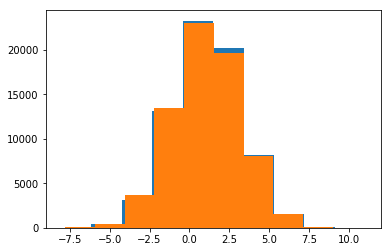

In [14]:
plt.hist(train_data[:,0], bins=10)
plt.hist(est_data_transformed[:,0], bins=10)
plt.show()

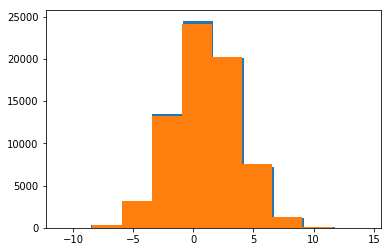

In [15]:
plt.hist(train_data[:,1], bins=10)
plt.hist(est_data_transformed[:,1], bins=10)
plt.show()

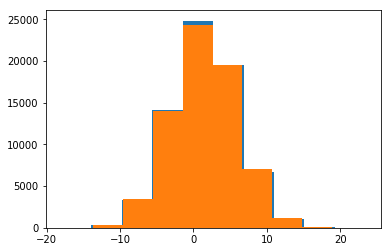

In [16]:
plt.hist(train_data[:,2], bins=10)
plt.hist(est_data_transformed[:,2], bins=10)
plt.show()

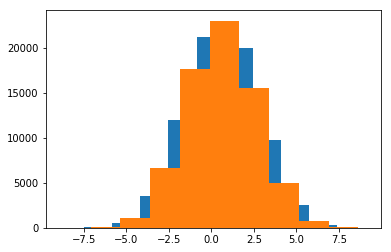

In [17]:
plt.hist(train_data[:,3], bins=10)
plt.hist(est_data_transformed[:,3], bins=10)
plt.show()

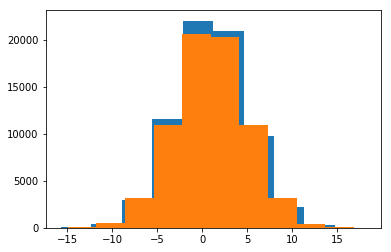

In [18]:
plt.hist(train_data[:,4], bins=10)
plt.hist(est_data_transformed[:,4], bins=10)
plt.show()

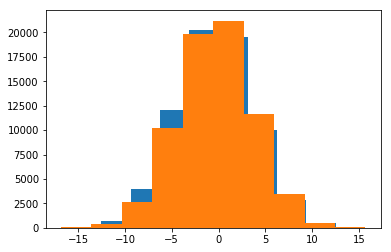

In [19]:
plt.hist(train_data[:,5], bins=10)
plt.hist(est_data_transformed[:,5], bins=10)
plt.show()

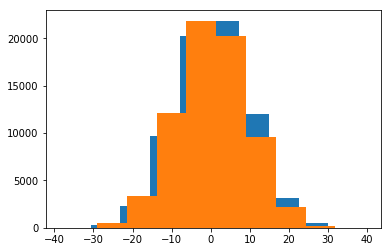

In [20]:
plt.hist(train_data[:,6], bins=10)
plt.hist(est_data_transformed[:,6], bins=10)
plt.show()

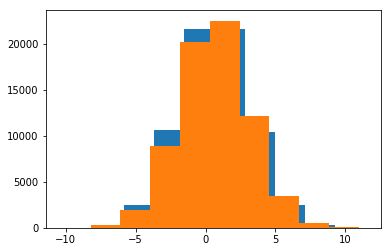

In [21]:
plt.hist(train_data[:,7], bins=10)
plt.hist(est_data_transformed[:,7], bins=10)
plt.show()

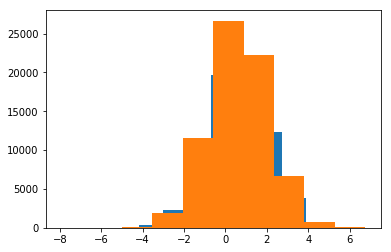

In [22]:
plt.hist(train_data[:,8], bins=10)
plt.hist(est_data_transformed[:,8], bins=10)
plt.show()

In [23]:
est_data_transformed.shape

(70000, 9)

In [24]:
z_total.shape

(70000, 7)

In [25]:
s_total.shape

(70000, 7)

In [26]:
s_total[0]

array([2.2888298e-06, 1.9745274e-02, 8.1390049e-04, 5.8901972e-13,
       4.0383762e-05, 9.7939819e-01, 2.8611188e-10], dtype=float32)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pyro
import pyro.distributions as dist

from tensorboardX import SummaryWriter

from tqdm import tqdm
import time

import random
from numpy.random import *
import matplotlib.pyplot as plt 
#np.random.seed(100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 1234
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [28]:
input_dim = len(data[0])-2
hidden_dim = 100
#output_dim = input_dim
cond_dim = 2
estimate_dim =1

In [29]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [30]:
def input_shaper(x,input_dim):
    return x.view(-1, input_dim).float()
    
def tag_shaper(tag):
    return torch.eye(2)[tag.long()].float()

In [31]:
class Estimator(nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim, estimate_dim):
        super(Estimator, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, estimate_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

In [32]:
print(split_point)
z_total_train = z_total[:split_point]
z_total_test = z_total[split_point:]
s_total_train = s_total[:split_point]
s_total_test = s_total[split_point:]

60000


In [33]:
sz_total_train = np.concatenate([z_total_train, s_total_train], 1)
sz_total_test = np.concatenate([z_total_test, s_total_test], 1)
print(sz_total_train.shape)
print(sz_total_test.shape)

(60000, 14)
(10000, 14)


## latent = s and z

In [34]:
latent_dim = args.dim_latent_s + args.dim_latent_z

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [35]:
for epoch in range(1, 200):
    start = 0
    for _data in tqdm(train_loader):
        y = tag_shaper(_data[:,0])
#         x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
#         x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
#         z = q.sample({"x":x}, return_all=False)
#         latent = z.get('z')
        
        end = start + batch_size
        latent = torch.tensor(sz_total_train[start:end]).to(device)
        start = end
        
        output = model2(latent,y)
        loss = criterion(output,o)        
        loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    start = 0
    for _data in test_loader:
        y = tag_shaper(_data[:,0])
#         x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
#         x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
#         z = q.sample({"x":x}, return_all=False)
#         latent = z.get('z')
        
        end = start + batch_size
        latent = torch.tensor(sz_total_test[start:end]).to(device)
        start = end        
        
        output = model2(latent,y)
        loss = criterion(output,o)
        
        total_loss += loss *len(_data)
        total += len(_data)
    test_loss = total_loss/total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch,loss.item(), test_loss.item()))

 11%|█▏        | 68/600 [00:00<00:00, 675.26it/s]

Epochs:1, train_Loss:2.275063991546631, test_Loss:1.47


 11%|█▏        | 68/600 [00:00<00:00, 675.71it/s]

Epochs:2, train_Loss:1.9857100248336792, test_Loss:1.29


 12%|█▏        | 70/600 [00:00<00:00, 691.02it/s]

Epochs:3, train_Loss:1.9124665260314941, test_Loss:1.25


 11%|█▏        | 68/600 [00:00<00:00, 674.35it/s]

Epochs:4, train_Loss:1.885416865348816, test_Loss:1.22


 11%|█         | 67/600 [00:00<00:00, 669.12it/s]

Epochs:5, train_Loss:1.8770751953125, test_Loss:1.21


 12%|█▏        | 69/600 [00:00<00:00, 681.19it/s]

Epochs:6, train_Loss:1.8734123706817627, test_Loss:1.19


 11%|█         | 67/600 [00:00<00:00, 669.21it/s]

Epochs:7, train_Loss:1.8733900785446167, test_Loss:1.18


 11%|█▏        | 68/600 [00:00<00:00, 671.92it/s]

Epochs:8, train_Loss:1.876213550567627, test_Loss:1.18


 11%|█▏        | 68/600 [00:00<00:00, 671.53it/s]

Epochs:9, train_Loss:1.8790454864501953, test_Loss:1.17


 11%|█▏        | 68/600 [00:00<00:00, 677.98it/s]

Epochs:10, train_Loss:1.8835315704345703, test_Loss:1.16


 12%|█▏        | 69/600 [00:00<00:00, 682.34it/s]

Epochs:11, train_Loss:1.8887983560562134, test_Loss:1.16


 12%|█▏        | 69/600 [00:00<00:00, 683.41it/s]

Epochs:12, train_Loss:1.8932629823684692, test_Loss:1.16


 11%|█▏        | 68/600 [00:00<00:00, 670.55it/s]

Epochs:13, train_Loss:1.8971202373504639, test_Loss:1.15


 12%|█▏        | 69/600 [00:00<00:00, 680.77it/s]

Epochs:14, train_Loss:1.9003182649612427, test_Loss:1.15


 12%|█▏        | 69/600 [00:00<00:00, 687.93it/s]

Epochs:15, train_Loss:1.9037885665893555, test_Loss:1.15


 12%|█▏        | 69/600 [00:00<00:00, 681.04it/s]

Epochs:16, train_Loss:1.9073724746704102, test_Loss:1.15


 11%|█▏        | 68/600 [00:00<00:00, 675.90it/s]

Epochs:17, train_Loss:1.9099879264831543, test_Loss:1.14


 12%|█▏        | 69/600 [00:00<00:00, 680.69it/s]

Epochs:18, train_Loss:1.910972237586975, test_Loss:1.14


 11%|█▏        | 68/600 [00:00<00:00, 679.65it/s]

Epochs:19, train_Loss:1.9123798608779907, test_Loss:1.14


 11%|█▏        | 68/600 [00:00<00:00, 677.56it/s]

Epochs:20, train_Loss:1.9136191606521606, test_Loss:1.14


 12%|█▏        | 69/600 [00:00<00:00, 689.47it/s]

Epochs:21, train_Loss:1.915049433708191, test_Loss:1.14


 12%|█▏        | 69/600 [00:00<00:00, 680.07it/s]

Epochs:22, train_Loss:1.9163200855255127, test_Loss:1.14


 11%|█▏        | 68/600 [00:00<00:00, 674.80it/s]

Epochs:23, train_Loss:1.9185824394226074, test_Loss:1.14


 12%|█▏        | 69/600 [00:00<00:00, 680.86it/s]

Epochs:24, train_Loss:1.920006275177002, test_Loss:1.14


 11%|█         | 67/600 [00:00<00:00, 667.84it/s]

Epochs:25, train_Loss:1.9214309453964233, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 673.34it/s]

Epochs:26, train_Loss:1.9234577417373657, test_Loss:1.13


 12%|█▏        | 70/600 [00:00<00:00, 692.46it/s]

Epochs:27, train_Loss:1.925251841545105, test_Loss:1.13


 12%|█▏        | 70/600 [00:00<00:00, 693.05it/s]

Epochs:28, train_Loss:1.9257915019989014, test_Loss:1.13


 12%|█▏        | 69/600 [00:00<00:00, 684.94it/s]

Epochs:29, train_Loss:1.9270989894866943, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 673.44it/s]

Epochs:30, train_Loss:1.9278857707977295, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 678.57it/s]

Epochs:31, train_Loss:1.9283846616744995, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 674.93it/s]

Epochs:32, train_Loss:1.927821397781372, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 677.46it/s]

Epochs:33, train_Loss:1.928135871887207, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 666.69it/s]

Epochs:34, train_Loss:1.9290903806686401, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 679.39it/s]

Epochs:35, train_Loss:1.9306361675262451, test_Loss:1.13


 11%|█         | 66/600 [00:00<00:00, 656.74it/s]

Epochs:36, train_Loss:1.9313608407974243, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 670.82it/s]

Epochs:37, train_Loss:1.9321544170379639, test_Loss:1.13


 22%|██▎       | 135/600 [00:00<00:00, 676.46it/s]

Epochs:38, train_Loss:1.9325315952301025, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 673.87it/s]

Epochs:39, train_Loss:1.9334614276885986, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 683.03it/s]

Epochs:40, train_Loss:1.933964729309082, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 672.28it/s]

Epochs:41, train_Loss:1.933605670928955, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 681.06it/s]

Epochs:42, train_Loss:1.9327647686004639, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 686.82it/s]

Epochs:43, train_Loss:1.9325308799743652, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 677.23it/s]

Epochs:44, train_Loss:1.932131052017212, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 667.62it/s]

Epochs:45, train_Loss:1.9321022033691406, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 670.87it/s]

Epochs:46, train_Loss:1.9316388368606567, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 667.86it/s]

Epochs:47, train_Loss:1.9315698146820068, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 681.25it/s]

Epochs:48, train_Loss:1.9319740533828735, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 675.66it/s]

Epochs:49, train_Loss:1.931848168373108, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 670.59it/s]

Epochs:50, train_Loss:1.9315757751464844, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 689.71it/s]

Epochs:51, train_Loss:1.931592345237732, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 685.38it/s]

Epochs:52, train_Loss:1.932059645652771, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 688.53it/s]

Epochs:53, train_Loss:1.9318623542785645, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 679.91it/s]

Epochs:54, train_Loss:1.9319348335266113, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 680.23it/s]

Epochs:55, train_Loss:1.9318556785583496, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 680.87it/s]

Epochs:56, train_Loss:1.9320741891860962, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 670.69it/s]

Epochs:57, train_Loss:1.932181715965271, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 683.80it/s]

Epochs:58, train_Loss:1.931980848312378, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 676.40it/s]

Epochs:59, train_Loss:1.9329087734222412, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 682.15it/s]

Epochs:60, train_Loss:1.9334454536437988, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 666.30it/s]

Epochs:61, train_Loss:1.933862328529358, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 678.35it/s]

Epochs:62, train_Loss:1.9333925247192383, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 678.26it/s]

Epochs:63, train_Loss:1.934767246246338, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 674.77it/s]

Epochs:64, train_Loss:1.9350696802139282, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 681.85it/s]

Epochs:65, train_Loss:1.9353575706481934, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 676.25it/s]

Epochs:66, train_Loss:1.9365724325180054, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 673.43it/s]

Epochs:67, train_Loss:1.9367594718933105, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 667.40it/s]

Epochs:68, train_Loss:1.9370208978652954, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 676.88it/s]

Epochs:69, train_Loss:1.9379030466079712, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 672.16it/s]

Epochs:70, train_Loss:1.93834388256073, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 672.05it/s]

Epochs:71, train_Loss:1.9395095109939575, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 667.93it/s]

Epochs:72, train_Loss:1.9399794340133667, test_Loss:1.12


 12%|█▏        | 69/600 [00:00<00:00, 686.34it/s]

Epochs:73, train_Loss:1.9402800798416138, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 675.74it/s]

Epochs:74, train_Loss:1.9402430057525635, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 677.54it/s]

Epochs:75, train_Loss:1.9405255317687988, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 667.69it/s]

Epochs:76, train_Loss:1.9406558275222778, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 678.92it/s]

Epochs:77, train_Loss:1.9407447576522827, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 678.94it/s]

Epochs:78, train_Loss:1.9408931732177734, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 676.19it/s]

Epochs:79, train_Loss:1.9413295984268188, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 685.43it/s]

Epochs:80, train_Loss:1.9410492181777954, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.28it/s]

Epochs:81, train_Loss:1.941170334815979, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 668.96it/s]

Epochs:82, train_Loss:1.9413598775863647, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.86it/s]

Epochs:83, train_Loss:1.941762089729309, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 669.89it/s]

Epochs:84, train_Loss:1.9425227642059326, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.98it/s]

Epochs:85, train_Loss:1.9425482749938965, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 685.69it/s]

Epochs:86, train_Loss:1.9427447319030762, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.35it/s]

Epochs:87, train_Loss:1.9429017305374146, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 681.75it/s]

Epochs:88, train_Loss:1.9426262378692627, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 684.94it/s]

Epochs:89, train_Loss:1.9429699182510376, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.72it/s]

Epochs:90, train_Loss:1.9432621002197266, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 677.05it/s]

Epochs:91, train_Loss:1.9432947635650635, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 686.58it/s]

Epochs:92, train_Loss:1.943613052368164, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 683.35it/s]

Epochs:93, train_Loss:1.9437217712402344, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 668.11it/s]

Epochs:94, train_Loss:1.943739652633667, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 677.55it/s]

Epochs:95, train_Loss:1.9438655376434326, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.36it/s]

Epochs:96, train_Loss:1.9442815780639648, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 661.54it/s]

Epochs:97, train_Loss:1.944425344467163, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 656.88it/s]

Epochs:98, train_Loss:1.9443851709365845, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 671.45it/s]

Epochs:99, train_Loss:1.9448670148849487, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.77it/s]

Epochs:100, train_Loss:1.9455041885375977, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.82it/s]

Epochs:101, train_Loss:1.94534432888031, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.43it/s]

Epochs:102, train_Loss:1.945397138595581, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 666.42it/s]

Epochs:103, train_Loss:1.945322871208191, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 662.85it/s]

Epochs:104, train_Loss:1.9456537961959839, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.15it/s]

Epochs:105, train_Loss:1.9457136392593384, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.97it/s]

Epochs:106, train_Loss:1.9458097219467163, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 687.40it/s]

Epochs:107, train_Loss:1.9459469318389893, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.38it/s]

Epochs:108, train_Loss:1.9460145235061646, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.11it/s]

Epochs:109, train_Loss:1.94599187374115, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.94it/s]

Epochs:110, train_Loss:1.9460978507995605, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 677.80it/s]

Epochs:111, train_Loss:1.945934534072876, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.93it/s]

Epochs:112, train_Loss:1.945867896080017, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 687.21it/s]

Epochs:113, train_Loss:1.9456121921539307, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.55it/s]

Epochs:114, train_Loss:1.945461630821228, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.65it/s]

Epochs:115, train_Loss:1.945470929145813, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.69it/s]

Epochs:116, train_Loss:1.9455941915512085, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.90it/s]

Epochs:117, train_Loss:1.945569396018982, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 672.44it/s]

Epochs:118, train_Loss:1.945469856262207, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.32it/s]

Epochs:119, train_Loss:1.9453097581863403, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.32it/s]

Epochs:120, train_Loss:1.9454381465911865, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 656.38it/s]

Epochs:121, train_Loss:1.9452890157699585, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 648.73it/s]

Epochs:122, train_Loss:1.9454152584075928, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.36it/s]

Epochs:123, train_Loss:1.9453493356704712, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.16it/s]

Epochs:124, train_Loss:1.9455609321594238, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.89it/s]

Epochs:125, train_Loss:1.945644497871399, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.61it/s]

Epochs:126, train_Loss:1.9455018043518066, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.81it/s]

Epochs:127, train_Loss:1.9455121755599976, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 678.28it/s]

Epochs:128, train_Loss:1.9455281496047974, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.10it/s]

Epochs:129, train_Loss:1.9453433752059937, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.18it/s]

Epochs:130, train_Loss:1.9452811479568481, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.23it/s]

Epochs:131, train_Loss:1.9455138444900513, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.72it/s]

Epochs:132, train_Loss:1.9457640647888184, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.91it/s]

Epochs:133, train_Loss:1.945741891860962, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.17it/s]

Epochs:134, train_Loss:1.9453749656677246, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.12it/s]

Epochs:135, train_Loss:1.945532202720642, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.80it/s]

Epochs:136, train_Loss:1.9453332424163818, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.65it/s]

Epochs:137, train_Loss:1.9452418088912964, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.73it/s]

Epochs:138, train_Loss:1.945212960243225, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.57it/s]

Epochs:139, train_Loss:1.9450750350952148, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 663.59it/s]

Epochs:140, train_Loss:1.9449315071105957, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.57it/s]

Epochs:141, train_Loss:1.9445364475250244, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 668.12it/s]

Epochs:142, train_Loss:1.944573163986206, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.22it/s]

Epochs:143, train_Loss:1.9445351362228394, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 671.16it/s]

Epochs:144, train_Loss:1.9443888664245605, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.27it/s]

Epochs:145, train_Loss:1.9440405368804932, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.20it/s]

Epochs:146, train_Loss:1.9440195560455322, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 671.99it/s]

Epochs:147, train_Loss:1.9440535306930542, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.86it/s]

Epochs:148, train_Loss:1.9439586400985718, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 652.91it/s]

Epochs:149, train_Loss:1.944020390510559, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 656.41it/s]

Epochs:150, train_Loss:1.9440221786499023, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.07it/s]

Epochs:151, train_Loss:1.9441066980361938, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 668.98it/s]

Epochs:152, train_Loss:1.9441624879837036, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 663.84it/s]

Epochs:153, train_Loss:1.9442774057388306, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 672.48it/s]

Epochs:154, train_Loss:1.9445512294769287, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.24it/s]

Epochs:155, train_Loss:1.944556713104248, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.83it/s]

Epochs:156, train_Loss:1.9446369409561157, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.46it/s]

Epochs:157, train_Loss:1.9446746110916138, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.29it/s]

Epochs:158, train_Loss:1.94497811794281, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 661.72it/s]

Epochs:159, train_Loss:1.944868564605713, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.05it/s]

Epochs:160, train_Loss:1.9451005458831787, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.40it/s]

Epochs:161, train_Loss:1.9451518058776855, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.11it/s]

Epochs:162, train_Loss:1.9451884031295776, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 685.03it/s]

Epochs:163, train_Loss:1.945555329322815, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 662.19it/s]

Epochs:164, train_Loss:1.945896029472351, test_Loss:1.11


 11%|█         | 64/600 [00:00<00:00, 638.26it/s]

Epochs:165, train_Loss:1.9463233947753906, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 666.62it/s]

Epochs:166, train_Loss:1.9464868307113647, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.07it/s]

Epochs:167, train_Loss:1.9469387531280518, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.03it/s]

Epochs:168, train_Loss:1.9473410844802856, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.62it/s]

Epochs:169, train_Loss:1.9475359916687012, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 677.89it/s]

Epochs:170, train_Loss:1.9477742910385132, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.50it/s]

Epochs:171, train_Loss:1.9480335712432861, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.78it/s]

Epochs:172, train_Loss:1.9482474327087402, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.52it/s]

Epochs:173, train_Loss:1.9486169815063477, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 666.78it/s]

Epochs:174, train_Loss:1.9489096403121948, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.77it/s]

Epochs:175, train_Loss:1.9491244554519653, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 663.83it/s]

Epochs:176, train_Loss:1.9491857290267944, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 679.94it/s]

Epochs:177, train_Loss:1.9495552778244019, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.58it/s]

Epochs:178, train_Loss:1.9499409198760986, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.31it/s]

Epochs:179, train_Loss:1.9501136541366577, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.72it/s]

Epochs:180, train_Loss:1.9504166841506958, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 676.57it/s]

Epochs:181, train_Loss:1.950576663017273, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.96it/s]

Epochs:182, train_Loss:1.9509541988372803, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.81it/s]

Epochs:183, train_Loss:1.951177716255188, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 672.35it/s]

Epochs:184, train_Loss:1.951439380645752, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 678.04it/s]

Epochs:185, train_Loss:1.9516962766647339, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.84it/s]

Epochs:186, train_Loss:1.9518747329711914, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 666.50it/s]

Epochs:187, train_Loss:1.9518580436706543, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.04it/s]

Epochs:188, train_Loss:1.9519988298416138, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 683.40it/s]

Epochs:189, train_Loss:1.9518073797225952, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.40it/s]

Epochs:190, train_Loss:1.9520293474197388, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 685.02it/s]

Epochs:191, train_Loss:1.9521209001541138, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 681.77it/s]

Epochs:192, train_Loss:1.9522689580917358, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 689.12it/s]

Epochs:193, train_Loss:1.9523624181747437, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 683.01it/s]

Epochs:194, train_Loss:1.9523000717163086, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.78it/s]

Epochs:195, train_Loss:1.9528998136520386, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 648.59it/s]

Epochs:196, train_Loss:1.9529880285263062, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.47it/s]

Epochs:197, train_Loss:1.9529372453689575, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 682.94it/s]

Epochs:198, train_Loss:1.9532569646835327, test_Loss:1.11


100%|██████████| 600/600 [00:00<00:00, 677.27it/s]


Epochs:199, train_Loss:1.953334927558899, test_Loss:1.11


In [36]:
pt_size = 20000
z_sample = 0.3* torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
uy_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated=model2(z_sample,uy_sample)

# 治療群を生成
plot_number = 1
ty_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated=model2(z_sample,ty_sample)

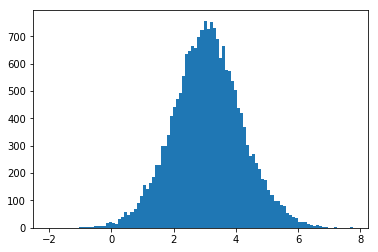

In [37]:
plt.hist(untreated.detach().cpu().numpy(),bins=100)
plt.show()

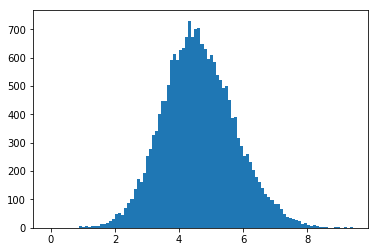

In [38]:
plt.hist(treated.detach().cpu().numpy(),bins=100)
plt.show()

1.5265381

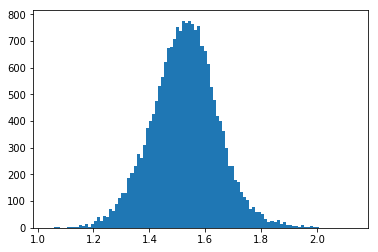

In [39]:
plt.hist(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy(),bins=100)
(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy()).mean()

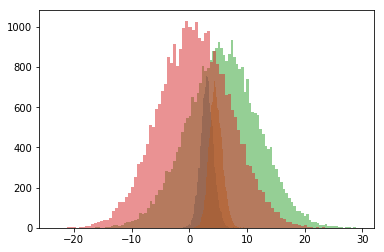

In [40]:
plt.hist(untreated.detach().cpu().numpy(), bins=100, alpha=0.5)
plt.hist(treated.detach().cpu().numpy(), bins=100, alpha=0.5)

plt.hist(df_train[(df_train[0]==1)][10], bins=100, alpha=0.5)
plt.hist(df_train[(df_train[0]==0)][10], bins=100, alpha=0.5)
plt.show()

## latent = z only

In [41]:
latent_dim = args.dim_latent_z

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [42]:
for epoch in range(1, 200):
    start = 0
    for _data in tqdm(train_loader):
        y = tag_shaper(_data[:,0])
#         x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
#         x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
#         z = q.sample({"x":x}, return_all=False)
#         latent = z.get('z')
        
        end = start + batch_size
        latent = torch.tensor(z_total_train[start:end]).to(device)
        start = end
        
        output = model2(latent,y)
        loss = criterion(output,o)        
        loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    start = 0
    for _data in test_loader:
        y = tag_shaper(_data[:,0])
#         x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
#         x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
#         z = q.sample({"x":x}, return_all=False)
#         latent = z.get('z')
        
        end = start + batch_size
        latent = torch.tensor(z_total_test[start:end]).to(device)
        start = end        
        
        output = model2(latent,y)
        loss = criterion(output,o)
        
        total_loss += loss *len(_data)
        total += len(_data)
    test_loss = total_loss/total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch,loss.item(), test_loss.item()))

 12%|█▏        | 69/600 [00:00<00:00, 684.24it/s]

Epochs:1, train_Loss:2.2163479328155518, test_Loss:1.42


 11%|█▏        | 68/600 [00:00<00:00, 677.96it/s]

Epochs:2, train_Loss:1.9788169860839844, test_Loss:1.25


 12%|█▏        | 69/600 [00:00<00:00, 683.98it/s]

Epochs:3, train_Loss:1.9241180419921875, test_Loss:1.21


 11%|█         | 67/600 [00:00<00:00, 663.88it/s]

Epochs:4, train_Loss:1.895931601524353, test_Loss:1.19


 11%|█         | 67/600 [00:00<00:00, 668.94it/s]

Epochs:5, train_Loss:1.879949927330017, test_Loss:1.18


 12%|█▏        | 69/600 [00:00<00:00, 683.95it/s]

Epochs:6, train_Loss:1.8744183778762817, test_Loss:1.17


 11%|█▏        | 68/600 [00:00<00:00, 670.61it/s]

Epochs:7, train_Loss:1.8739757537841797, test_Loss:1.17


 12%|█▏        | 69/600 [00:00<00:00, 683.04it/s]

Epochs:8, train_Loss:1.8752107620239258, test_Loss:1.16


 12%|█▏        | 70/600 [00:00<00:00, 693.06it/s]

Epochs:9, train_Loss:1.8780311346054077, test_Loss:1.16


 12%|█▏        | 69/600 [00:00<00:00, 686.92it/s]

Epochs:10, train_Loss:1.8808164596557617, test_Loss:1.16


 11%|█         | 67/600 [00:00<00:00, 669.14it/s]

Epochs:11, train_Loss:1.8849279880523682, test_Loss:1.15


 11%|█         | 67/600 [00:00<00:00, 667.35it/s]

Epochs:12, train_Loss:1.8890604972839355, test_Loss:1.15


 11%|█▏        | 68/600 [00:00<00:00, 677.07it/s]

Epochs:13, train_Loss:1.8929418325424194, test_Loss:1.15


 11%|█         | 67/600 [00:00<00:00, 664.36it/s]

Epochs:14, train_Loss:1.8977084159851074, test_Loss:1.15


 12%|█▏        | 69/600 [00:00<00:00, 682.45it/s]

Epochs:15, train_Loss:1.9021834135055542, test_Loss:1.15


 12%|█▏        | 69/600 [00:00<00:00, 680.97it/s]

Epochs:16, train_Loss:1.9046350717544556, test_Loss:1.15


 11%|█▏        | 68/600 [00:00<00:00, 677.93it/s]

Epochs:17, train_Loss:1.9064764976501465, test_Loss:1.15


 11%|█         | 66/600 [00:00<00:00, 652.25it/s]

Epochs:18, train_Loss:1.9075291156768799, test_Loss:1.14


 11%|█         | 67/600 [00:00<00:00, 662.01it/s]

Epochs:19, train_Loss:1.909105896949768, test_Loss:1.14


 11%|█         | 65/600 [00:00<00:00, 640.90it/s]

Epochs:20, train_Loss:1.9097654819488525, test_Loss:1.14


 11%|█         | 66/600 [00:00<00:00, 655.77it/s]

Epochs:21, train_Loss:1.909361720085144, test_Loss:1.14


 11%|█         | 64/600 [00:00<00:00, 638.30it/s]

Epochs:22, train_Loss:1.9092357158660889, test_Loss:1.14


 11%|█         | 65/600 [00:00<00:00, 645.22it/s]

Epochs:23, train_Loss:1.9094173908233643, test_Loss:1.14


 11%|█         | 65/600 [00:00<00:00, 644.04it/s]

Epochs:24, train_Loss:1.90949547290802, test_Loss:1.14


 11%|█         | 66/600 [00:00<00:00, 651.88it/s]

Epochs:25, train_Loss:1.9095330238342285, test_Loss:1.14


 10%|█         | 62/600 [00:00<00:00, 618.85it/s]

Epochs:26, train_Loss:1.9094784259796143, test_Loss:1.14


 11%|█         | 65/600 [00:00<00:00, 646.71it/s]

Epochs:27, train_Loss:1.9098345041275024, test_Loss:1.14


 11%|█         | 66/600 [00:00<00:00, 654.94it/s]

Epochs:28, train_Loss:1.909571886062622, test_Loss:1.14


 11%|█         | 67/600 [00:00<00:00, 660.68it/s]

Epochs:29, train_Loss:1.9093937873840332, test_Loss:1.14


 11%|█         | 65/600 [00:00<00:00, 648.20it/s]

Epochs:30, train_Loss:1.9085767269134521, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 665.33it/s]

Epochs:31, train_Loss:1.908712387084961, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 661.20it/s]

Epochs:32, train_Loss:1.9081612825393677, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 660.64it/s]

Epochs:33, train_Loss:1.9081854820251465, test_Loss:1.13


 11%|█         | 66/600 [00:00<00:00, 657.91it/s]

Epochs:34, train_Loss:1.9076752662658691, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 669.67it/s]

Epochs:35, train_Loss:1.908074140548706, test_Loss:1.13


 11%|█         | 66/600 [00:00<00:00, 651.99it/s]

Epochs:36, train_Loss:1.9078716039657593, test_Loss:1.13


 11%|█         | 66/600 [00:00<00:00, 657.59it/s]

Epochs:37, train_Loss:1.9080781936645508, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 672.11it/s]

Epochs:38, train_Loss:1.9081951379776, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 674.64it/s]

Epochs:39, train_Loss:1.909194827079773, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 662.63it/s]

Epochs:40, train_Loss:1.9097554683685303, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 673.26it/s]

Epochs:41, train_Loss:1.9102970361709595, test_Loss:1.13


 12%|█▏        | 69/600 [00:00<00:00, 683.97it/s]

Epochs:42, train_Loss:1.9103314876556396, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 674.62it/s]

Epochs:43, train_Loss:1.9113186597824097, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 665.94it/s]

Epochs:44, train_Loss:1.911862850189209, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 668.12it/s]

Epochs:45, train_Loss:1.9128005504608154, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 665.42it/s]

Epochs:46, train_Loss:1.9137848615646362, test_Loss:1.13


 11%|█         | 65/600 [00:00<00:00, 645.12it/s]

Epochs:47, train_Loss:1.9146713018417358, test_Loss:1.13


 11%|█         | 66/600 [00:00<00:00, 657.70it/s]

Epochs:48, train_Loss:1.9151523113250732, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 672.11it/s]

Epochs:49, train_Loss:1.9157871007919312, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 663.21it/s]

Epochs:50, train_Loss:1.9164743423461914, test_Loss:1.13


 11%|█▏        | 68/600 [00:00<00:00, 670.24it/s]

Epochs:51, train_Loss:1.9166566133499146, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 669.15it/s]

Epochs:52, train_Loss:1.9169201850891113, test_Loss:1.13


 11%|█         | 67/600 [00:00<00:00, 669.64it/s]

Epochs:53, train_Loss:1.9168025255203247, test_Loss:1.12


 11%|█         | 66/600 [00:00<00:00, 655.74it/s]

Epochs:54, train_Loss:1.9170277118682861, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 668.58it/s]

Epochs:55, train_Loss:1.916914463043213, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 661.91it/s]

Epochs:56, train_Loss:1.9173462390899658, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 669.28it/s]

Epochs:57, train_Loss:1.9172943830490112, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 663.49it/s]

Epochs:58, train_Loss:1.917292594909668, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 676.83it/s]

Epochs:59, train_Loss:1.9173551797866821, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 662.65it/s]

Epochs:60, train_Loss:1.9176831245422363, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 660.83it/s]

Epochs:61, train_Loss:1.918139934539795, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 660.01it/s]

Epochs:62, train_Loss:1.9183070659637451, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 675.67it/s]

Epochs:63, train_Loss:1.9182950258255005, test_Loss:1.12


 11%|█         | 66/600 [00:00<00:00, 657.41it/s]

Epochs:64, train_Loss:1.9181618690490723, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 668.52it/s]

Epochs:65, train_Loss:1.9181606769561768, test_Loss:1.12


 11%|█         | 65/600 [00:00<00:00, 639.87it/s]

Epochs:66, train_Loss:1.9182626008987427, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 669.22it/s]

Epochs:67, train_Loss:1.9183837175369263, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 664.24it/s]

Epochs:68, train_Loss:1.9184755086898804, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 666.14it/s]

Epochs:69, train_Loss:1.9187325239181519, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 670.38it/s]

Epochs:70, train_Loss:1.918992519378662, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 664.59it/s]

Epochs:71, train_Loss:1.9191936254501343, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 678.47it/s]

Epochs:72, train_Loss:1.919067621231079, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 671.22it/s]

Epochs:73, train_Loss:1.9189409017562866, test_Loss:1.12


 11%|█         | 65/600 [00:00<00:00, 640.94it/s]

Epochs:74, train_Loss:1.919339656829834, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 661.62it/s]

Epochs:75, train_Loss:1.9199085235595703, test_Loss:1.12


 11%|█         | 66/600 [00:00<00:00, 657.91it/s]

Epochs:76, train_Loss:1.9198554754257202, test_Loss:1.12


 11%|█         | 65/600 [00:00<00:00, 646.55it/s]

Epochs:77, train_Loss:1.9199955463409424, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 673.46it/s]

Epochs:78, train_Loss:1.9200472831726074, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 664.75it/s]

Epochs:79, train_Loss:1.920230507850647, test_Loss:1.12


 11%|█         | 66/600 [00:00<00:00, 654.19it/s]

Epochs:80, train_Loss:1.920340895652771, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 669.30it/s]

Epochs:81, train_Loss:1.920314073562622, test_Loss:1.12


 11%|█         | 66/600 [00:00<00:00, 655.66it/s]

Epochs:82, train_Loss:1.9203590154647827, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 662.08it/s]

Epochs:83, train_Loss:1.9203073978424072, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 664.45it/s]

Epochs:84, train_Loss:1.9201717376708984, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 660.13it/s]

Epochs:85, train_Loss:1.9201911687850952, test_Loss:1.12


 10%|█         | 63/600 [00:00<00:00, 623.68it/s]

Epochs:86, train_Loss:1.9201231002807617, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 675.83it/s]

Epochs:87, train_Loss:1.919978380203247, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 678.24it/s]

Epochs:88, train_Loss:1.9198271036148071, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 677.08it/s]

Epochs:89, train_Loss:1.9197709560394287, test_Loss:1.12


 11%|█         | 65/600 [00:00<00:00, 642.02it/s]

Epochs:90, train_Loss:1.9195858240127563, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 664.84it/s]

Epochs:91, train_Loss:1.9193965196609497, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 670.57it/s]

Epochs:92, train_Loss:1.9191365242004395, test_Loss:1.12


 11%|█         | 66/600 [00:00<00:00, 656.65it/s]

Epochs:93, train_Loss:1.91911780834198, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 672.55it/s]

Epochs:94, train_Loss:1.919062852859497, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 663.50it/s]

Epochs:95, train_Loss:1.919146180152893, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 671.16it/s]

Epochs:96, train_Loss:1.9191089868545532, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 667.99it/s]

Epochs:97, train_Loss:1.9189093112945557, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 673.71it/s]

Epochs:98, train_Loss:1.9187105894088745, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 660.21it/s]

Epochs:99, train_Loss:1.9185909032821655, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 675.47it/s]

Epochs:100, train_Loss:1.9187949895858765, test_Loss:1.12


 11%|█         | 67/600 [00:00<00:00, 666.61it/s]

Epochs:101, train_Loss:1.9186466932296753, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 672.52it/s]

Epochs:102, train_Loss:1.9187355041503906, test_Loss:1.12


 11%|█▏        | 68/600 [00:00<00:00, 676.98it/s]

Epochs:103, train_Loss:1.9188587665557861, test_Loss:1.12


 11%|█         | 65/600 [00:00<00:00, 647.80it/s]

Epochs:104, train_Loss:1.9191235303878784, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.23it/s]

Epochs:105, train_Loss:1.9191110134124756, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.59it/s]

Epochs:106, train_Loss:1.9190477132797241, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.78it/s]

Epochs:107, train_Loss:1.9192218780517578, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.48it/s]

Epochs:108, train_Loss:1.9193696975708008, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.65it/s]

Epochs:109, train_Loss:1.9195678234100342, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.27it/s]

Epochs:110, train_Loss:1.9198055267333984, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 663.00it/s]

Epochs:111, train_Loss:1.9201503992080688, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 646.44it/s]

Epochs:112, train_Loss:1.9202985763549805, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 649.36it/s]

Epochs:113, train_Loss:1.9203100204467773, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 641.27it/s]

Epochs:114, train_Loss:1.9206942319869995, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 671.99it/s]

Epochs:115, train_Loss:1.9212265014648438, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.24it/s]

Epochs:116, train_Loss:1.9218189716339111, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 677.26it/s]

Epochs:117, train_Loss:1.922152042388916, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 652.19it/s]

Epochs:118, train_Loss:1.9224039316177368, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 652.21it/s]

Epochs:119, train_Loss:1.9227497577667236, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 648.67it/s]

Epochs:120, train_Loss:1.9230557680130005, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.86it/s]

Epochs:121, train_Loss:1.9233009815216064, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 666.45it/s]

Epochs:122, train_Loss:1.9237163066864014, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.23it/s]

Epochs:123, train_Loss:1.9241893291473389, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.29it/s]

Epochs:124, train_Loss:1.9249435663223267, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 655.18it/s]

Epochs:125, train_Loss:1.925220251083374, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.55it/s]

Epochs:126, train_Loss:1.92558753490448, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.79it/s]

Epochs:127, train_Loss:1.9259533882141113, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.06it/s]

Epochs:128, train_Loss:1.9264979362487793, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 656.17it/s]

Epochs:129, train_Loss:1.9268745183944702, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.86it/s]

Epochs:130, train_Loss:1.9272042512893677, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 653.87it/s]

Epochs:131, train_Loss:1.9271881580352783, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.82it/s]

Epochs:132, train_Loss:1.927404522895813, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.66it/s]

Epochs:133, train_Loss:1.9278085231781006, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.53it/s]

Epochs:134, train_Loss:1.9282530546188354, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 656.58it/s]

Epochs:135, train_Loss:1.9288705587387085, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 661.97it/s]

Epochs:136, train_Loss:1.929190993309021, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 647.33it/s]

Epochs:137, train_Loss:1.9297242164611816, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.33it/s]

Epochs:138, train_Loss:1.929961085319519, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.41it/s]

Epochs:139, train_Loss:1.9303990602493286, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 652.30it/s]

Epochs:140, train_Loss:1.9307461977005005, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.12it/s]

Epochs:141, train_Loss:1.9311621189117432, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.79it/s]

Epochs:142, train_Loss:1.9313932657241821, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 663.39it/s]

Epochs:143, train_Loss:1.931671380996704, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.73it/s]

Epochs:144, train_Loss:1.931965947151184, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 671.09it/s]

Epochs:145, train_Loss:1.9323078393936157, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.99it/s]

Epochs:146, train_Loss:1.93255615234375, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.82it/s]

Epochs:147, train_Loss:1.9326953887939453, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 683.21it/s]

Epochs:148, train_Loss:1.932837724685669, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 662.09it/s]

Epochs:149, train_Loss:1.9330705404281616, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.50it/s]

Epochs:150, train_Loss:1.933266282081604, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.63it/s]

Epochs:151, train_Loss:1.9334193468093872, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.89it/s]

Epochs:152, train_Loss:1.9334744215011597, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.64it/s]

Epochs:153, train_Loss:1.9334495067596436, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.53it/s]

Epochs:154, train_Loss:1.9336942434310913, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 672.91it/s]

Epochs:155, train_Loss:1.9338452816009521, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.32it/s]

Epochs:156, train_Loss:1.9339697360992432, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 649.41it/s]

Epochs:157, train_Loss:1.9341362714767456, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.22it/s]

Epochs:158, train_Loss:1.934308409690857, test_Loss:1.11


 11%|█         | 64/600 [00:00<00:00, 632.94it/s]

Epochs:159, train_Loss:1.9349045753479004, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 658.20it/s]

Epochs:160, train_Loss:1.9352829456329346, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.55it/s]

Epochs:161, train_Loss:1.9353994131088257, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.24it/s]

Epochs:162, train_Loss:1.9356251955032349, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.91it/s]

Epochs:163, train_Loss:1.9357351064682007, test_Loss:1.11


 12%|█▏        | 69/600 [00:00<00:00, 680.85it/s]

Epochs:164, train_Loss:1.9359477758407593, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 663.43it/s]

Epochs:165, train_Loss:1.9359588623046875, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 653.14it/s]

Epochs:166, train_Loss:1.9360827207565308, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.79it/s]

Epochs:167, train_Loss:1.9361506700515747, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.23it/s]

Epochs:168, train_Loss:1.936440110206604, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.83it/s]

Epochs:169, train_Loss:1.9364451169967651, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 667.72it/s]

Epochs:170, train_Loss:1.9367479085922241, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.58it/s]

Epochs:171, train_Loss:1.9367632865905762, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.21it/s]

Epochs:172, train_Loss:1.9369081258773804, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 665.74it/s]

Epochs:173, train_Loss:1.937042236328125, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 678.33it/s]

Epochs:174, train_Loss:1.9373900890350342, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 677.48it/s]

Epochs:175, train_Loss:1.9375052452087402, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 668.67it/s]

Epochs:176, train_Loss:1.937814712524414, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 664.49it/s]

Epochs:177, train_Loss:1.9381072521209717, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 674.26it/s]

Epochs:178, train_Loss:1.9384127855300903, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 662.44it/s]

Epochs:179, train_Loss:1.9382340908050537, test_Loss:1.11


 11%|█         | 64/600 [00:00<00:00, 639.28it/s]

Epochs:180, train_Loss:1.9384074211120605, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 657.51it/s]

Epochs:181, train_Loss:1.9386091232299805, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 673.32it/s]

Epochs:182, train_Loss:1.9385679960250854, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 659.22it/s]

Epochs:183, train_Loss:1.9385994672775269, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 666.21it/s]

Epochs:184, train_Loss:1.9386837482452393, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.93it/s]

Epochs:185, train_Loss:1.9389417171478271, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 675.72it/s]

Epochs:186, train_Loss:1.939087986946106, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 660.24it/s]

Epochs:187, train_Loss:1.9392234086990356, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 678.19it/s]

Epochs:188, train_Loss:1.9394769668579102, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 655.81it/s]

Epochs:189, train_Loss:1.939316987991333, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 652.63it/s]

Epochs:190, train_Loss:1.9394718408584595, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 650.83it/s]

Epochs:191, train_Loss:1.9396613836288452, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 643.71it/s]

Epochs:192, train_Loss:1.9398599863052368, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 668.95it/s]

Epochs:193, train_Loss:1.9399545192718506, test_Loss:1.11


 11%|█         | 65/600 [00:00<00:00, 648.78it/s]

Epochs:194, train_Loss:1.9401178359985352, test_Loss:1.11


 11%|█         | 66/600 [00:00<00:00, 651.74it/s]

Epochs:195, train_Loss:1.9402551651000977, test_Loss:1.11


 11%|█▏        | 68/600 [00:00<00:00, 670.65it/s]

Epochs:196, train_Loss:1.9402681589126587, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.32it/s]

Epochs:197, train_Loss:1.9405237436294556, test_Loss:1.11


 11%|█         | 67/600 [00:00<00:00, 669.77it/s]

Epochs:198, train_Loss:1.940633773803711, test_Loss:1.11


100%|██████████| 600/600 [00:00<00:00, 660.55it/s]

Epochs:199, train_Loss:1.9406424760818481, test_Loss:1.11


In [43]:
pt_size = 20000
z_sample = 0.3* torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
uy_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated=model2(z_sample,uy_sample)

# 治療群を生成
plot_number = 1
ty_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated=model2(z_sample,ty_sample)

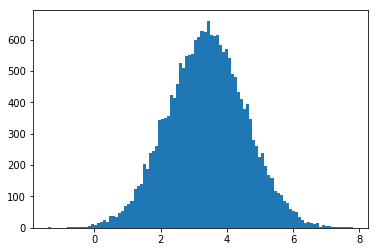

In [44]:
plt.hist(untreated.detach().cpu().numpy(),bins=100)
plt.show()

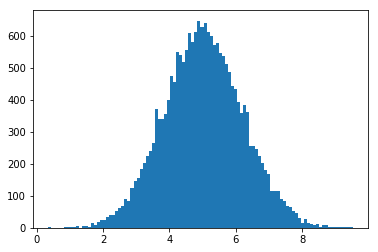

In [45]:
plt.hist(treated.detach().cpu().numpy(),bins=100)
plt.show()

1.6357293

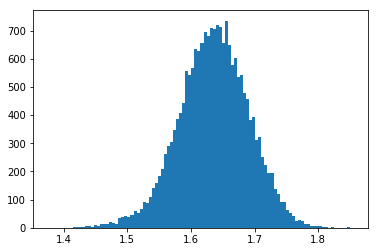

In [46]:
plt.hist(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy(),bins=100)
(treated.detach().cpu().numpy()-untreated.detach().cpu().numpy()).mean()

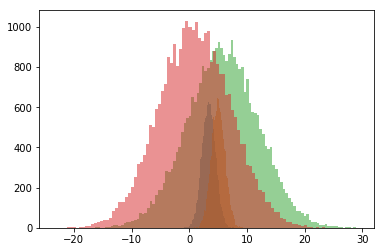

In [47]:
plt.hist(untreated.detach().cpu().numpy(), bins=100, alpha=0.5)
plt.hist(treated.detach().cpu().numpy(), bins=100, alpha=0.5)

plt.hist(df_train[(df_train[0]==1)][10], bins=100, alpha=0.5)
plt.hist(df_train[(df_train[0]==0)][10], bins=100, alpha=0.5)
plt.show()